## Naive Bayes & Mixed Data Types | Heart Disease Dataset


##### 1. Background
Naive Bayes is a binary classification algorithm, which is essentially based on Bayes Optimal Classifier, and Baye's Theorem. This algorithm is a generative learning algorithm, thus we compute $P(x|y)$ for each binary target value, such that the target with the highest probability is the output target.

The function for predicting targets can be stated as: <br>
$h(x) = argmax_y\prod_{\alpha=1}^{d}P(x_\alpha|y)\cdot P(y)$ 
<br>
    
Two things to note about this algorithm is that it assumes the following when computing $P(x|y)$:
1. All features are treated as independent events. Thus the total probability is the product of each feature's probability: $P(A,B) = P(A)\cdot P(B)$ , where $P(A)$, $P(B)$ are independent events.
2. From the function $h(x)$ we can see that the probability is computed using a specified probability distribution. Naive Bayes assumes that the provided distribution models our data. Thus we must select a probability distribution that well represents our features.

##### 2. Purpose of this Notebook
The purpose of this notebook is to demonstrate how we can use Naive Bayes classifier when our features consist of different distribution types. 
##### 3. Notebook Scope
As the purpose of this notebook is to primarily demonstrate how to work with mixed data distributions when using Naive Bayes classifier, no data manipulation and visualization will be conducted.

##### 4. The Dataset
We will use the Heart Disease public dataset from the 'UCI Machine Learning Repository', as it includes various different data types (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). With this dataset we are seeking to predict whether a patient is at risk of heart disease. Targets with a value of 1 equate to 'heart disease present' and targets with a value of 0 equate to 'absence of heart disease.' 


In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data
data = pd.read_csv('heartdisease.csv')

#display first 5 rows
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
%%html
<style>
  table {float: left}
</style>

##### Explanation of Features

|Feature | Data Type | Comments |
|--|---|:---|
|age |continuous |- |
|sex |binary |- |
|cp |categorical |chest pain type |
|trestbps |continuous |resting blood pressure|
|chol|continuous|cholestrol|
|fbs|binary|fasting blood sugar > 120mg/dl|
|restecg|categorical|resting electrocardiographic results|
|thalach|continuous|max heart rate achieved
|exang|binary|exercise induced angina|
|oldpeak|continuous|ST depression induced by exercise relative to rest|
|slope|categorical|slope of peak exercise ST segment
|ca|discrete|number of major vessels colored by flouroscopy|
|thal|categorical|thalassemia|

From the table above we can see we have features from four different distributions. 

#### 5. Target Distribution

Text(0, 0.5, 'Count')

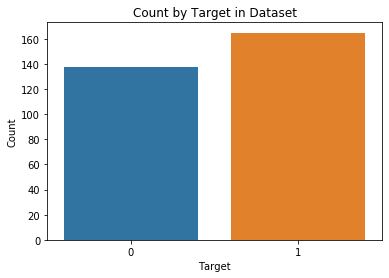

In [5]:
#determining balance of targets
sns.countplot(data.target)
plt.title('Count by Target in Dataset')
plt.xlabel('Target')
plt.ylabel('Count')

Our dataset is well balanced. Therefore we can continue without worrying about skewed results due to a biased dataset. 

##### 6. Continuous Variables
We will now explore our continuous data. Since we are using the sklearn libary, we will use the GaussianNB to model our continous data. Let's ensure that our continuous features are approximately gaussian.

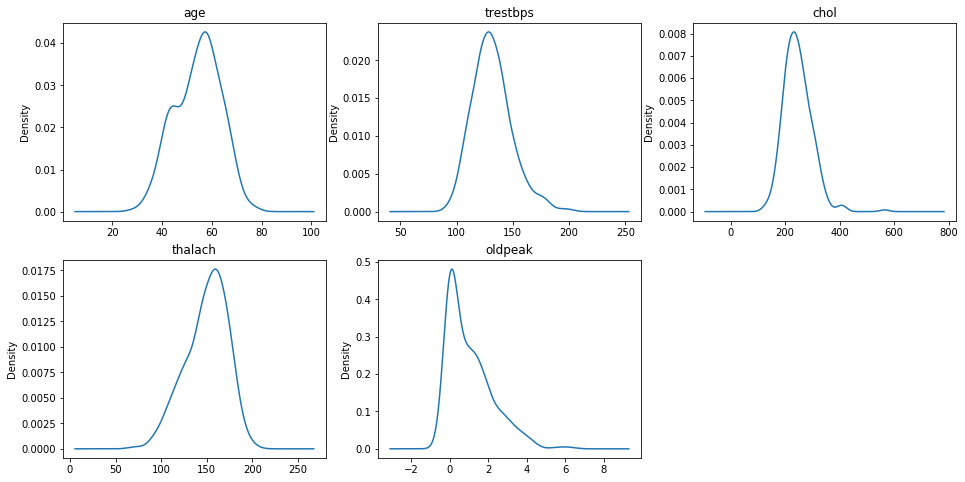

In [6]:
#selecting continuous features
continuous = ['age', 'trestbps', 'chol','thalach','oldpeak']

#plotting distributions of continuous features
fig, ax = plt.subplots(2,3)
fig.set_figheight(8)
fig.set_figwidth(16)

i = 0
n = 0

while i < 2:      
    j = 0
    while j < 3:
        if n == 5:
            ax[1,2].axis('off')
            break
        data[continuous[n]].plot(kind='kde', ax=ax[i,j], title=continuous[n])
        n+=1
        j+=1
    i+= 1

The following can be noted about the above distribution plots:
- age: approx. gaussian
- trestbps: approx. gaussian, slightly skewed to the right
- chol: approx. gaussian, skewed to the right
- thalach: approx. gaussian, skewed to let
- oldpeak: exponential distribution

Let's adjust these distributions so that we get accurate results when modelling these features as gaussian distribution when computing $P(x|y)$ 

###### a. Oldpeak

First, we will convert oldpeak into a categorical feature by placing the feature into bins.

In [7]:
#splitting oldpeak values into bins
oldpeak_cat = pd.cut(data.oldpeak, bins=12)
data['oldpeak_cat'] = oldpeak_cat

#converting bins into categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data.oldpeak_cat = le.fit_transform(data.oldpeak_cat)
data.drop('oldpeak', axis=1, inplace=True)

###### b. Trestbps

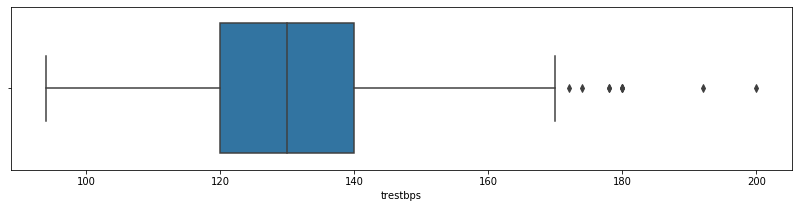

In [8]:
#plot box plot for trestbps
plt.figure(figsize=(14,3))
sns.boxplot(data.trestbps)

In [9]:
#checking shape of data
data.shape

(303, 14)

I only have 303 observations, thus I am wary to drop observations that will minimize the dataset further. I will adjust the outliers such that they have a value of 165. This is reasonable, as a trestbps of 140 equates to High Blood Pressure, and a trestbps of 180 equates to Hypertensive Crisis. I am not bothered in the severity of one's heart disease, only whether a patient is at risk of having heart disease or not. Thus slightly lowering the trestbps for patients with exceptionally high blood pressure should not impact my results since the value it is being lowered to still falls into the range of having high blood pressure.

In [10]:
#reducing trestbps to 165
data.trestbps[data.trestbps>165] = 165

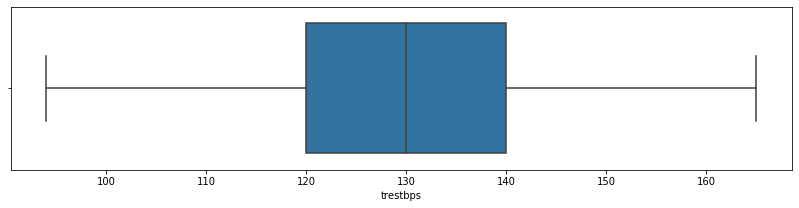

In [11]:
#plot box plot for trestbps
plt.figure(figsize=(14,3))
sns.boxplot(data.trestbps)

Our trestbps feature now looks approximately gaussian.

##### c. Chol

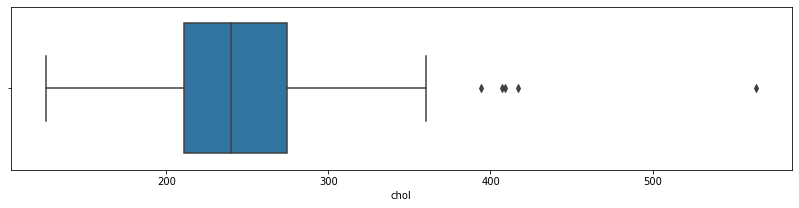

In [12]:
#plot box plot for cholestrol
plt.figure(figsize=(14,3))
sns.boxplot(data.chol)

Again, we have many outliers that I do not want to drop, so we will apply the same logic and reduce the value of outliers for cholestrol to 330 (High cholestrol is classified as >240). Again, this should not impact our classifier, as we are not looking for the severity of one's heart disease, just whether a patient is at risk or not. 

In [13]:
#reducing chol outliers to 330
data.chol[data.chol > 350] = 350

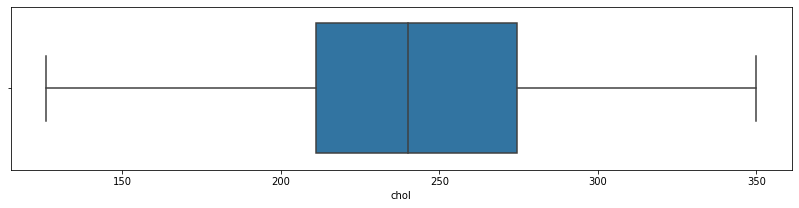

In [14]:
#plot box plot for cholestrol
plt.figure(figsize=(14,3))
sns.boxplot(data.chol)

Our chol feature now looks approximately gaussian.

###### d. Thalach

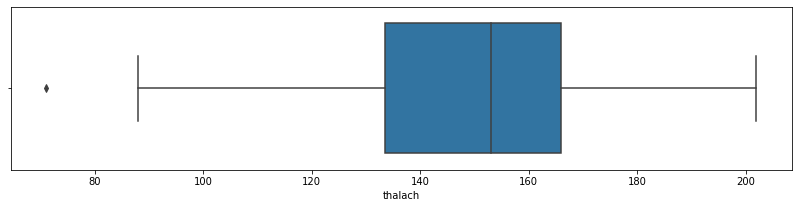

In [15]:
#plotting box plot for the max heart rate achieved
plt.figure(figsize=(14,3))
sns.boxplot(data.thalach)

Our feature is skewed to the left. We will apply the same logic and adjust outliers.

In [16]:
#finding the average age for our data
data.age.mean()

54.366336633663366

For a 54 year old, the average heart rate for weight control activity is between 99bpm. So we will set outliers at 99bpm.

In [17]:
#raising upliers to 91bpm
data.thalach[data.thalach < 99] = 99

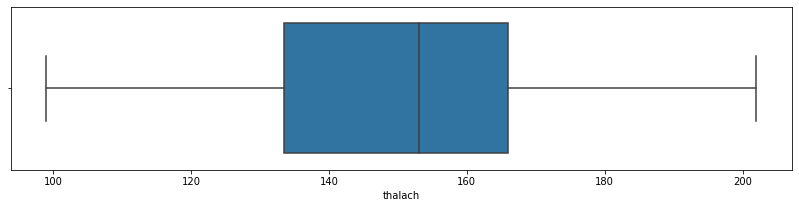

In [18]:
#plotting box plot for the max heart rate achieved
plt.figure(figsize=(14,3))
sns.boxplot(data.thalach)

Our plot is still skewed to the left. However, it is still more gaussian than it originally was.

#### 7. Modelling Our Data

Our dataset has features with four different data types:
- Continuous
- Discrete
- Categorical
- Multinomial

Thus, we will have to compute probabilities using Naive Bayes for each distribution seperately.

What will we do next? Since Naive Bayes makes the assumption that all features are considered independent, we can compute the total probability $P(x|y)$ by taking the product of the probabilities rendered from each distribution type:

$P(x|y) = P(x_{gaussian}|y) \cdot P(x_{categorical}|y) \cdot P(x_{multinomial}|y) \cdot P(x_{bernoulli}|y)$

We can then train our model using total probability values and the Gaussian Naive Bayes algorithm (since our probabilities are continuous and assumed to be gaussian) to make predictions.

In [19]:
#importing and instantiating Naive Bayes algorithms

from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB

g_NB = GaussianNB()
m_NB = MultinomialNB()
cat_NB = CategoricalNB()
bern_NB = BernoulliNB()

In [20]:
#splitting our data into a training and test set
from sklearn.model_selection import train_test_split

y = data.target
X = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
#seperating our features by data-type
continuous = ['age', 'trestbps', 'chol','thalach']
discrete = ['ca']
categorical = ['cp','restecg','slope','thal','oldpeak_cat']
binary = ['sex','fbs','exang']

In [23]:
#training our NB models
g_NB.fit(X_train[continuous], y_train)
m_NB.fit(X_train[discrete], y_train)
cat_NB.fit(X_train[categorical], y_train)
bern_NB.fit(X_train[binary], y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

We need to set up the final Gaussian Naive Bayes model that we will use for final classification. The input to this model will be the probabilities from our trained models.

Note: We will be using the log probabilities. This is because mutliplying small numbers (probabilities) by one another results in even smaller numbers that are harder to seperate. Thus we want our values as large as possible so that the final product can be more easily distinguishable.

In [24]:
#getting the probabilities for our training set
g_log_probs = g_NB.predict_log_proba(X_train[continuous])
m_log_probs = m_NB.predict_log_proba(X_train[discrete])
cat_log_probs = cat_NB.predict_log_proba(X_train[categorical])
bern_log_probs = bern_NB.predict_log_proba(X_train[binary])

In [25]:
#computing the probabilities by taking the product of all probabilities
prob = g_log_probs * m_log_probs * cat_log_probs * bern_log_probs

In [26]:
#training final gaussian model
g_final_NB = GaussianNB()
g_final_NB.fit(prob, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

##### 8. Testing the Model

In [27]:
#getting the probabilities for our test set
g_log_probs_test = g_NB.predict_log_proba(X_test[continuous])
m_log_probs_test = m_NB.predict_log_proba(X_test[discrete])
cat_log_probs_test = cat_NB.predict_log_proba(X_test[categorical])
bern_log_probs_test = bern_NB.predict_log_proba(X_test[binary])

In [28]:
#computing the probabilities by taking the product of all probabilities
prob_test = g_log_probs_test * m_log_probs_test * cat_log_probs_test * bern_log_probs_test

In [29]:
#classifying test data
y_hat = g_final_NB.predict(prob_test)

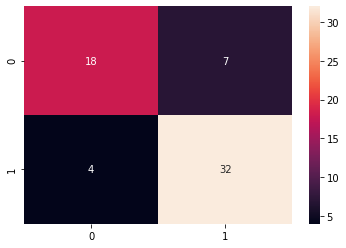

In [30]:
#evaluating our model
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True)

In [37]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        25
           1       0.82      0.89      0.85        36

    accuracy                           0.82        61
   macro avg       0.82      0.80      0.81        61
weighted avg       0.82      0.82      0.82        61



The weighted F1-score for this model is 0.82, this can be improved upon by experimenting with other algorithms, including more features, using a larger dataset, and so forth. The model predicted 7 false positives, and 4 false negatives. Having false positives is not a major concern for this model as the patient can undergo tests to identify that there are no abnormalities. However, false negatives are of concern as the patient can be identified as a low risk patient when they are in fact at high risk - resulting in a lack of treatment for their risk level and condition. That being said, our recall value is 0.89, which is fairly okay for this scenario, and could be improved through trying different algorithms to model our dataset. As the scope of this notebook was to demonstrate how to use Naive Bayes with different data distributions, we will not explore other algorithms in this specific notebook.